In [1]:
import pandas as pd
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import random
import sys
from sklearn.metrics.pairwise import cosine_similarity
from sgt import SGT
import numpy as np
import plotly.graph_objects as go
import umap 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os 

In [2]:
PATH = "temp_data/sessions_full.parquet"
#PATH = "temp_data/sessions_30.parquet"

## I.  Read data

In [3]:
# read the parquet file
sessions = pd.read_parquet(PATH)

In [4]:
# actions value counts
actions = sessions['action'].value_counts(normalize=True) * 100
actions

simple_search               30.789814
next_page                   21.785991
document_access             21.439175
prev_page                    6.571709
filtering_search_results     4.605041
chosen_page                  3.090379
first_page                   2.335862
zoom                         2.111513
document_download            1.975234
page_download                1.441500
blog_navigation              0.916057
to_single_page_mode          0.840829
homepage                     0.642561
revisit_document             0.552547
heading_navigation           0.458309
to_multi_page_mode           0.187050
advanced_search              0.167612
to_vertical_page_mode        0.040605
to_double_page_mode          0.031658
to_audio_page_mode           0.016554
Name: action, dtype: float64

In [5]:
# plot the actions value counts (show percentage in the plot)
fig = px.bar(actions, x=actions.index, y=actions.values, text=actions.values, labels={'x':'Action', 'y':'Percentage'})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
# height of 600 and width of 1000
fig.update_layout(height=600, width=1000)
# title
fig.update_layout(title_text='Actions Value Counts')
fig.show()


In [6]:
# map child actions to parent actions
actions_map = {
    'homepage': 'homepage',
    'blog_navigation': 'blog',
    'heading_navigation': 'heading',
    'simple_search': 'search',
    'advanced_search': 'advanced_search',
    'filtering_search_results': 'filtering_search_results',
    'document_access': 'document',
    'prev_page': 'pagination',
    'next_page': 'pagination',
    'first_page': 'pagination',
    'chosen_page': 'pagination',
    'revisit_document': 'revisit_document',
    'zoom': 'engagement',
    'to_single_page_mode': 'engagement',
    'to_double_page_mode': 'engagement',
    'to_vertical_page_mode': 'engagement',
    'to_audio_page_mode': 'engagement',
    'to_multi_page_mode': 'engagement',
    'page_download': 'download',
    'document_download': 'download',
}

In [7]:
# map actions to parent actions
sessions['parent_action'] = sessions['action'].map(actions_map)

In [8]:
# parent actions value counts
parent_actions = sessions['parent_action'].value_counts(normalize=True) * 100
parent_actions

pagination                  33.783941
search                      30.789814
document                    21.439175
filtering_search_results     4.605041
download                     3.416734
engagement                   3.228209
blog                         0.916057
homepage                     0.642561
revisit_document             0.552547
heading                      0.458309
advanced_search              0.167612
Name: parent_action, dtype: float64

In [9]:
# plot the parent actions value counts (show percentage in the plot)
fig = px.bar(parent_actions, x=parent_actions.index, y=parent_actions.values, text=parent_actions.values, labels={'x':'Action', 'y':'Percentage'})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
# height of 600 and width of 1000
fig.update_layout(height=600, width=1000)
# title
fig.update_layout(title_text='Parent Actions Value Counts ')
fig.show()

In [10]:
# Calculate the number of actions per session
actions_per_session = sessions.groupby(
    'session_id')['action'].count().reset_index(name='actions_per_session')
sessions['sequence_length'] = sessions['session_id'].map(
    actions_per_session.set_index('session_id')['actions_per_session'])

count    622958.000000
mean         67.297461
std         322.950102
min           1.000000
0%            1.000000
5%            4.000000
10%           5.000000
15%           6.000000
20%           8.000000
25%           9.000000
30%          11.000000
35%          13.000000
40%          16.000000
45%          19.000000
50%          22.000000
55%          27.000000
60%          32.000000
65%          39.000000
70%          48.000000
75%          60.000000
80%          77.000000
85%         102.000000
90%         144.000000
95%         230.000000
max       37415.000000
Name: actions_per_session, dtype: float64


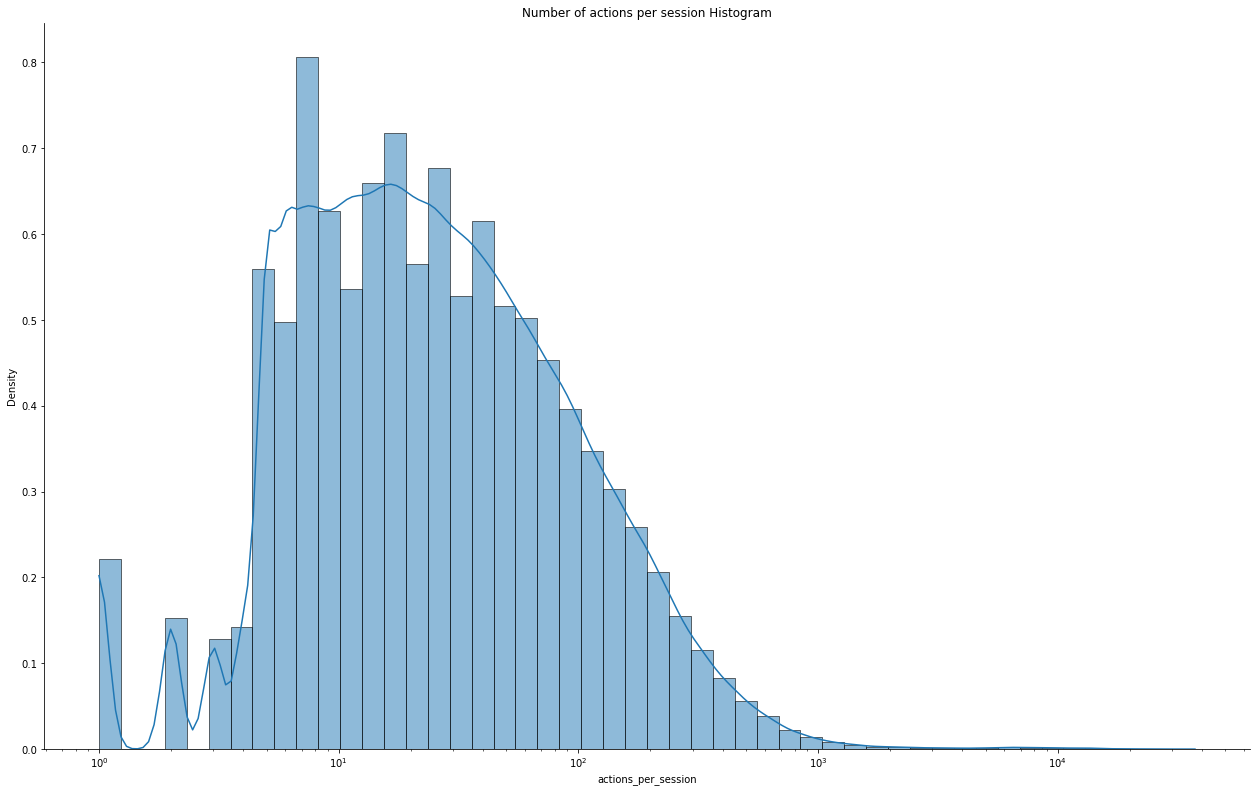

In [11]:
percentiles = np.arange(0, 1, 0.05)
# Create a histogram plot with Seaborn (freq = True)
sns.displot(actions_per_session, x="actions_per_session",
            bins=50, log_scale=(True, False), kde=True, stat="density")
# height of 600 and width of 1000
plt.gcf().set_size_inches(20, 12)
# title
plt.title('Number of actions per session Histogram')

# Print statistics using pandas describe method
print(actions_per_session["actions_per_session"].describe(
    percentiles=percentiles))

In [12]:
# plot number of sessions per day 
sessions['date'] = sessions['timestamp'].dt.date
sessions_per_day = sessions.groupby('date')['session_id'].nunique().reset_index(name='sessions_per_day')
fig = px.line(sessions_per_day, x="date", y="sessions_per_day", title='Number of sessions per day', height=800, width=1000)
fig.show()

# remove date column
sessions = sessions.drop(columns=['date'])

In [13]:
print("Number of sessions: ", sessions['session_id'].nunique())

Number of sessions:  622958


In [14]:
# consider only session where the number of actions is between 3 and 1000
sessions = sessions.loc[sessions['sequence_length'].between(4, 230)]

In [15]:
print("Number of sessions: ", sessions['session_id'].nunique())

Number of sessions:  563215


In [16]:
def plot_transition_heatmap(sessions, parent_actions=False, normlisation='line'):
    if parent_actions:
        sequences = sessions.groupby('session_id')['parent_action'].apply(list)
        title = 'Transition Heatmap between parent actions'
    else:
        sequences = sessions.groupby('session_id')['action'].apply(list)
        title = 'Transition Heatmap between actions'


    # Create a list of transitions for each sequence
    transitions = []
    for sequence in sequences:
        for i in range(len(sequence) - 1):
            transitions.append((sequence[i], sequence[i + 1]))

    # Create transition matrix
    transition_matrix = pd.DataFrame(transitions, columns=['from', 'to'])
    transition_matrix = transition_matrix.groupby(['from', 'to']).size().reset_index(name='counts')
    transition_matrix = transition_matrix.pivot(index='from', columns='to', values='counts')
    transition_matrix = transition_matrix.fillna(0)
    if normlisation == 'line':
        transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    elif normlisation == 'column':
        transition_matrix = transition_matrix.div(transition_matrix.sum(axis=0), axis=1)

    # Plot the transition heatmap
    fig = plt.figure(figsize=(15, 13))  # Adjust the figure size as desired
    # viridis inverted colormap
    sns.heatmap(transition_matrix, cmap='viridis_r', annot=True, fmt='.2f', annot_kws={'size': 10})
    
    # Set plot title
    plt.title(title)

    # Show the plot
    plt.show()


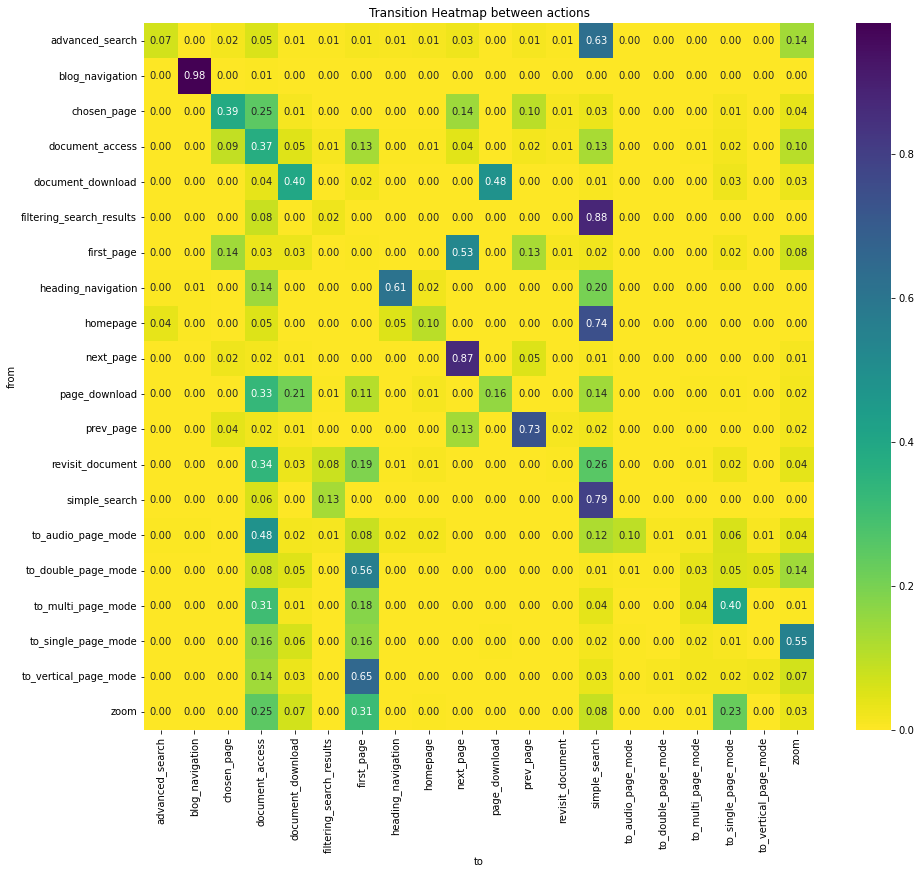

In [17]:
plot_transition_heatmap(sessions)

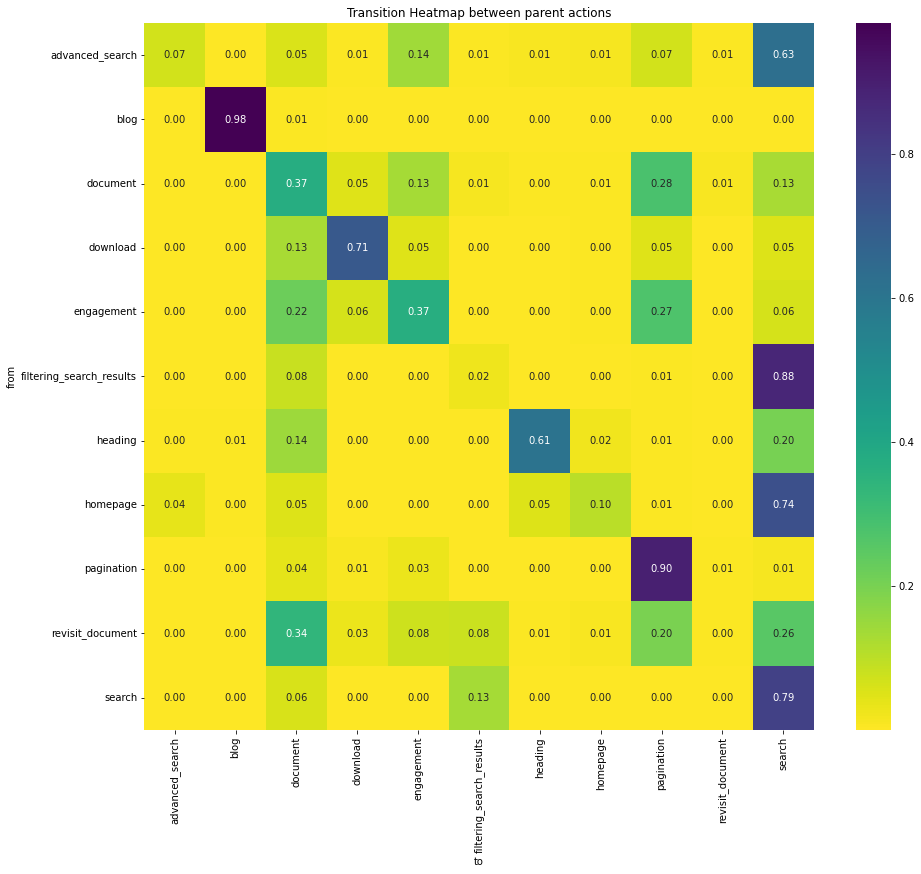

In [18]:
plot_transition_heatmap(sessions, parent_actions=True)

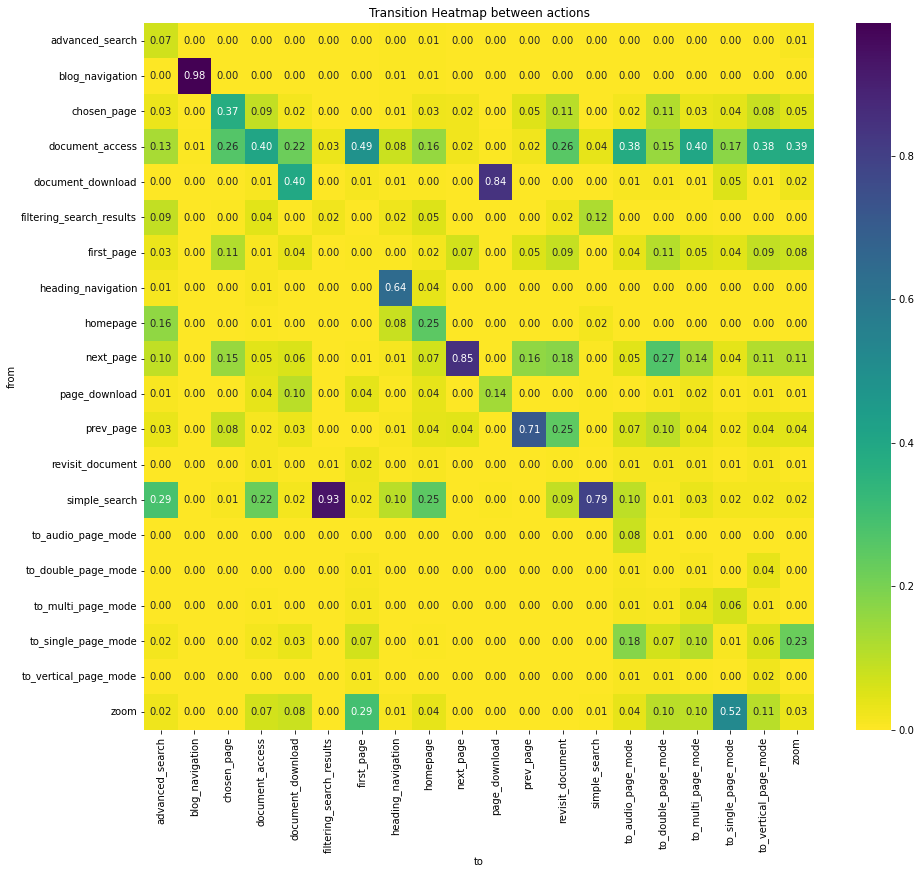

In [19]:
plot_transition_heatmap(sessions, normlisation='column')

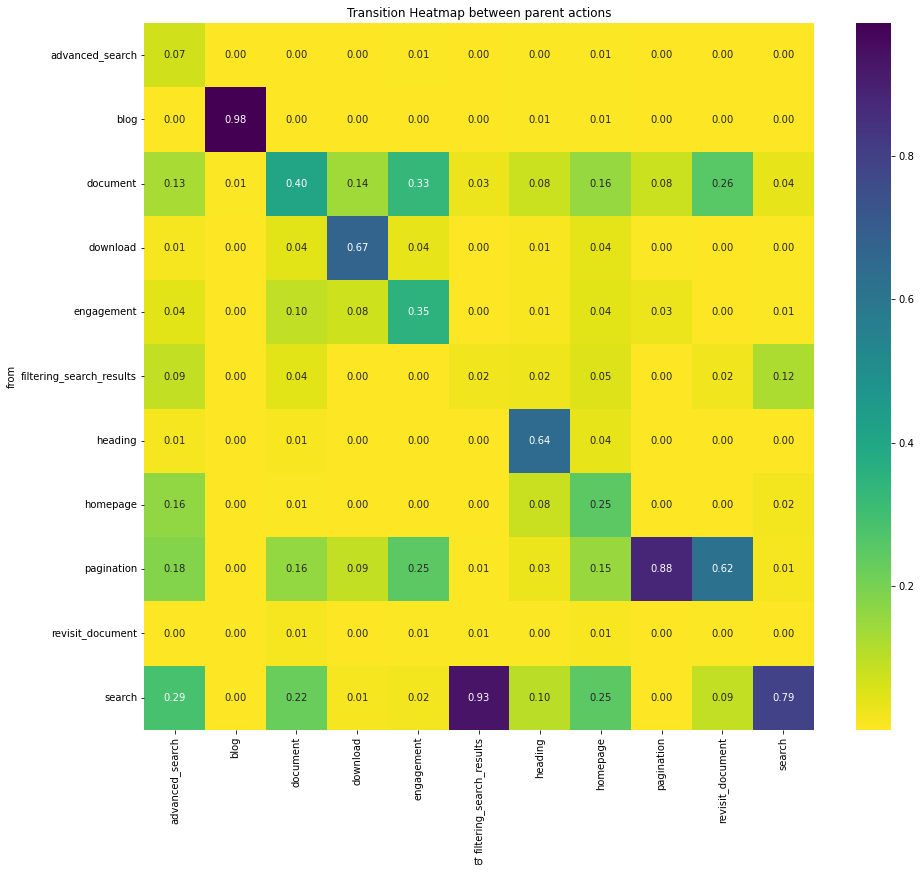

In [20]:
plot_transition_heatmap(sessions, parent_actions=True, normlisation='column')

## II. Sequence encoding

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# map child actions to parent actions
actions_map = {
    'homepage': 'homepage',
    'blog_navigation': 'blog',
    'heading_navigation': 'heading',
    'simple_search': 'search',
    'advanced_search': 'advanced_search',
    'filtering_search_results': 'filtering_search_results',
    'document_access': 'document',
    'prev_page': 'pagination',
    'next_page': 'pagination',
    'first_page': 'pagination',
    'chosen_page': 'pagination',
    'revisit_document': 'revisit_document',
    'zoom': 'engagement',
    'to_single_page_mode': 'engagement',
    'to_double_page_mode': 'engagement',
    'to_vertical_page_mode': 'engagement',
    'to_audio_page_mode': 'engagement',
    'to_multi_page_mode': 'engagement',
    'page_download': 'download',
    'document_download': 'download',
}

def encode_sequences(df, min_length=3, max_length=200, encode_using_parent_actions=True):
    """
    Encodes the sequences into integers using LabelEncoder

    Parameters:
    df (pandas.DataFrame): input data frame with columns session_id, action, timestamp, Ark, Sequence

    Returns:
    sequences (pandas.DataFrame): output data frame with columns session_id, Encoded_Sequence
    """
    # grouping actions by session_id and sorting them by timestamp
    df = df.sort_values(by=['session_id', 'timestamp'])
    # create a new column 'Sequence' containing a python list of actions for each session_id
    if encode_using_parent_actions:
        df['action'] = df['action'].map(actions_map)
    # Encode "action" column using LabelEncoder
    le = LabelEncoder()
    df['action_encoded'] = le.fit_transform(df['action'])

    # Group actions by "session_id" and concatenate them into sequences
    sequences = df.groupby('session_id').agg(
        {'action_encoded': lambda x: ' '.join(map(str, x))})
    sequences_timestamp = df.groupby('session_id').agg(
        {'timestamp': lambda x: list(x)})
    sequences_timestamp = sequences_timestamp.rename(
        columns={'timestamp': 'timestamp_list'})
    sequences = sequences.merge(sequences_timestamp, on='session_id')
    sequences = sequences.reset_index().rename(
        columns={'action_encoded': 'Encoded_Sequence'})
    
    # filter sequences by length
    sequences = sequences[sequences['Encoded_Sequence'].apply(
        lambda x: len(x.split(' '))) >= min_length]
    sequences = sequences[sequences['Encoded_Sequence'].apply(
        lambda x: len(x.split(' '))) <= max_length].reset_index(drop=True)

    # map to a list of integers
    list_of_sequences = sequences['Encoded_Sequence'].apply(
        lambda x: list(map(int, x.split(' '))))
    sequences['Encoded_Sequence_List'] = list_of_sequences


    # get mapping from action to integer
    action_to_int = dict(zip(le.classes_, le.transform(le.classes_)))

    # return the alphabet list 
    alphabet = list(le.transform(le.classes_))

    return sequences, action_to_int, alphabet

In [22]:
# call the function to encode sequences
sequences, action_to_int, alphabet = encode_sequences(sessions)

In [23]:
sequences

,session_id,Encoded_Sequence,timestamp_list,Encoded_Sequence_List
0,S_100_1_U_10190aa6e1f5e43d4797ea27ed0b2f90,7 0 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...,"[2016-02-25 21:51:13+01:00, 2016-02-25 21:51:1...","[7, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,..."
1,S_100_1_U_103ccfd7aeec86ad3b8215d54a6813ff,7 10 10 10 10 10 10 10 10 5 10 10 10 10 10 10 ...,"[2016-02-25 19:35:04+01:00, 2016-02-25 19:35:0...","[7, 10, 10, 10, 10, 10, 10, 10, 10, 5, 10, 10,..."
2,S_100_1_U_105d99d0283c958bbec1b1e977134d98,10 10 5 10 10 5 10 10 10 2 2 8 8 8 8 8 9 2 8 8...,"[2016-02-25 21:27:36+01:00, 2016-02-25 21:27:4...","[10, 10, 5, 10, 10, 5, 10, 10, 10, 2, 2, 8, 8,..."
3,S_100_1_U_106d44f07524737f39f789145dd6a2c3,10 10 10 10 10 5 10 10 10 10 10 10 5 10 10 10 ...,"[2016-02-25 19:48:45+01:00, 2016-02-25 19:48:4...","[10, 10, 10, 10, 10, 5, 10, 10, 10, 10, 10, 10..."
4,S_100_1_U_10762f1c093d4f8558adfd91be941630,8 8 8 8 8 8 8 8 8 8 8 8 8 8,"[2016-02-26 03:14:26+01:00, 2016-02-26 03:14:2...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]"
...,...,...,...,...
555349,S_9_3_U_a6bd9964674da1f9b4877b2d560b0ad9,2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 10 2 10 2,"[2016-02-03 05:15:28+01:00, 2016-02-03 05:15:4...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
555350,S_9_3_U_d661edc5b772caed74bfa1e7d7bdc180,10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 1...,"[2016-02-02 21:29:08+01:00, 2016-02-02 21:29:0...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
555351,S_9_3_U_f11ff4788f234428fb157248203261cc,2 2 2 10 2,"[2016-02-03 02:32:06+01:00, 2016-02-03 02:41:2...","[2, 2, 2, 10, 2]"
555352,S_9_4_U_62262265f1525d53f7cbf2b1fba327b3,2 2 2 2 2,"[2016-02-02 22:35:34+01:00, 2016-02-02 22:52:2...","[2, 2, 2, 2, 2]"


In [24]:
action_to_int

{'advanced_search': 0,
 'blog': 1,
 'document': 2,
 'download': 3,
 'engagement': 4,
 'filtering_search_results': 5,
 'heading': 6,
 'homepage': 7,
 'pagination': 8,
 'revisit_document': 9,
 'search': 10}

## III. SGT embeddings

In [25]:
def create_sgt_embeddings(df, kappa=0.01, lengthsensitive=False, mode='multiprocessing'):
    """
    Creates SGT embeddings of sequences

    Parameters:
    df (pandas.DataFrame): input data frame with columns session_id, action, timestamp, Ark, Sequence
    kappa (int): decay factor (default: 1)
    lengthsensitive (bool): whether to use length-sensitive SGT (default: False)
    mode (str): whether to use multiprocessing or not (default: 'multiprocessing')

    Returns:
    embeddings (numpy.ndarray): 2D array of shape (num_sessions, 100) containing sequence embeddings
    """
    # convert sequences to lists of words
    sequences = df['Encoded_Sequence'].apply(lambda x: x.split())

    # Compute SGT embeddings
    corpus = df[['session_id', 'Encoded_Sequence_List']].rename(
        columns={'session_id': 'id', 'Encoded_Sequence_List': 'sequence'})
    sgt_o = SGT(alphabets= alphabet, kappa=kappa,
               lengthsensitive=lengthsensitive,
               mode=mode)
    sgtembedding_df = sgt_o.fit_transform(corpus)

    # Set the id column as the dataframe index
    sgtembedding_df = sgtembedding_df.set_index('id')

    # extract the sequence embeddings (all columns except the sequence column)
    embeddings = sgtembedding_df[sgtembedding_df.columns.difference(
        ['sequence'])].values
    embeddings = np.array(embeddings)

    return embeddings

In [26]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np

def calculate_features(df, actions_column, timestamps_column):
    # Number of 'search' actions in a session
    df['search_count'] = df[actions_column].apply(lambda actions: actions.count('search')+actions.count('advanced_search')+actions.count('filtering_search_results'))

    # Number of 'document_access' actions in a session
    df['document_access_count'] = df[actions_column].apply(lambda actions: actions.count('document'))

    # Ratio of 'search' actions to 'document_access' actions
    df['search_to_doc_access_ratio'] = df['search_count'] / df['document_access_count']

    # Length of the session
    df['session_length'] = df[actions_column].apply(len)

    # Number of unique actions in a session
    df['unique_actions'] = df[actions_column].apply(lambda actions: len(set(actions)))

    # Average number of actions before document_access
    def actions_before_new_document(actions):
        if actions.count("document") > 1:
            indices = [i for i, x in enumerate(actions) if x == "document"]
            return np.mean(np.diff(indices))
        return np.nan

    df['avg_actions_before_doc_access'] = df[actions_column].apply(actions_before_new_document)

    # Average time between actions
    def avg_time_between_actions(timestamps):
        diffs = [(timestamps[i+1]-timestamps[i]).total_seconds() for i in range(len(timestamps)-1)]
        return np.mean(diffs) if diffs else np.nan

    df['avg_time_between_actions'] = df[timestamps_column].apply(avg_time_between_actions)

    # Session duration
    def session_duration(timestamps):
        return (max(timestamps)-min(timestamps)).total_seconds() if timestamps else np.nan

    df['session_duration'] = df[timestamps_column].apply(session_duration)

    # Handle inf and nan values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)

def visualize_clusters(sessions_grouped, directory, column, actions_column):
    # Calculate the number of sessions in each cluster
    cluster_sizes = sessions_grouped[column].value_counts().sort_index()
    print("Cluster sizes:")
    print(cluster_sizes , cluster_sizes/len(sessions_grouped)*100)
    # Calculate the mean session length in each cluster
    sessions_grouped['session_length'] = sessions_grouped[actions_column].apply(len)
    mean_session_lengths = sessions_grouped.groupby(column)['session_length'].mean()
    print("\nMean session lengths:")
    print(mean_session_lengths)

    # Calculate the average time between actions for each cluster
    avg_time_between_actions = sessions_grouped.groupby(column)['avg_time_between_actions'].mean()
    print("\nAverage Time between Actions:")
    print(avg_time_between_actions)

    # Calculate the average session duration for each cluster
    avg_session_duration = sessions_grouped.groupby(column)['session_duration'].mean()
    print("\nAverage Session Duration:")
    print(avg_session_duration)

    # Calculate the average number of document accesses per cluster
    def count_document_accesses(actions):
        return actions.count("document")

    avg_document_accesses = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.apply(count_document_accesses).mean())
    print("\nAverage Document Accesses per Cluster:")
    print(avg_document_accesses)

    # Calculate the average number of actions before a new document access
    def actions_before_new_document(actions):
        if actions.count("document") > 1:
            indices = [i for i, x in enumerate(actions) if x == "document"]
            return np.mean(np.diff(indices))
        return np.nan

    avg_actions_before_new_doc = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.apply(actions_before_new_document).mean())
    print("\nAverage Actions before New Document Access per Cluster:")
    print(avg_actions_before_new_doc)

    # Filter the actions to only include the page modes
    page_modes = ['to_single_page_mode', 'to_multi_page_mode', 'to_vertical_page_mode', 'to_double_page_mode', 'to_audio_page_mode']
    page_mode_counts = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.explode()[x.explode().isin(page_modes)].value_counts())
    page_mode_counts = page_mode_counts.unstack(level=-1).fillna(0)

    # Calculate the total count for each cluster
    total_page_mode_counts = page_mode_counts.sum(axis=1)

    # Calculate the average number of searches per cluster
    def count_search(actions):
        return actions.count("search") + actions.count("advanced_search")+ actions.count('filtering_search_results')

    avg_search = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.apply(count_search).mean())
    print("\nAverage searches per Cluster:")
    print(avg_search)
    
    # Calculate the action counts for each cluster
    cluster_action_counts = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.explode().value_counts())
    cluster_action_counts = cluster_action_counts.unstack(level=-1).fillna(0)

    # Get the top N most frequent actions
    N = 10
    top_actions = sessions_grouped[actions_column].explode().value_counts().head(N).index.tolist()

    # Filter to keep only the top N actions
    filtered_action_counts = cluster_action_counts[top_actions]

    # Calculate the total count for each cluster
    total_counts = filtered_action_counts.sum(axis=1)

    # Plot the actions distribution as a stacked bar chart
    print("Action distribution and percentage for each cluster:\n")
    print(filtered_action_counts.div(total_counts, axis=0).mul(100).round(1))

    fig, axes = plt.subplots(4, 2, figsize=(16, 20))  # 3 rows, 2 columns

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plot the cluster sizes
    sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis', ax=axes[0])
    axes[0].set_title("Cluster Sizes")
    axes[0].set_xlabel("Cluster")
    axes[0].set_ylabel("Number of Sessions")

    # Plot the mean session lengths
    sns.barplot(x=mean_session_lengths.index, y=mean_session_lengths.values, palette='viridis', ax=axes[1])
    axes[1].set_title("Mean Session Lengths per Cluster")
    axes[1].set_xlabel("Cluster")
    axes[1].set_ylabel("Mean Session Length")

    # Plot the mean document accesses
    sns.barplot(x=avg_document_accesses.index, y=avg_document_accesses.values, palette='viridis', ax=axes[2])
    axes[2].set_title("Mean Document Accesses per Cluster")
    axes[2].set_xlabel("Cluster")
    axes[2].set_ylabel("Mean Document Accesses")

    # Plot the mean search
    sns.barplot(x=avg_search.index, y=avg_search.values, palette='viridis', ax=axes[3])
    axes[3].set_title("Mean searches per Cluster")
    axes[3].set_xlabel("Cluster")
    axes[3].set_ylabel("Mean Searches")

    # Plot the mean actions before document access
    sns.barplot(x=avg_actions_before_new_doc.index, y=avg_actions_before_new_doc.values, palette='viridis', ax=axes[4])
    axes[4].set_title("Mean Actions before Document Access per Cluster")
    axes[4].set_xlabel("Cluster")
    axes[4].set_ylabel("Mean Actions before Document Access")

    # Plot the average time between actions
    sns.barplot(x=avg_time_between_actions.index, y=avg_time_between_actions.values, palette='viridis', ax=axes[5])
    axes[5].set_title("Average Time Between Actions per Cluster")
    axes[5].set_xlabel("Cluster")
    axes[5].set_ylabel("Average Time Between Actions")
    axes[5].set_yscale('log')  


    # Plot the average session duration
    sns.barplot(x=avg_session_duration.index, y=avg_session_duration.values, palette='viridis', ax=axes[6])
    axes[6].set_title("Average Session Duration per Cluster")
    axes[6].set_xlabel("Cluster")
    axes[6].set_ylabel("Average Session Duration")
    axes[6].set_yscale('log')  




    # Automatically adjust subplot params so that the subplotS fits in to the figure area
    plt.tight_layout()

    # Save and show the figure
    plt.savefig(os.path.join(directory, 'features.png'))
    plt.show()



    # Plot action distribution
    ax = filtered_action_counts.div(total_counts, axis=0).mul(100).plot(kind='bar', stacked=True, figsize=(12, 10))

    plt.title("Top {} Actions Distribution in Each Cluster".format(N))
    plt.xlabel("Cluster")
    plt.ylabel("Percentage of Actions")
    plt.legend(title="Actions", loc='upper left', bbox_to_anchor=(1, 1))

    # Add percentages on top of the stacked bars
    for i, rects in enumerate(ax.containers):
        for rect in rects:
            height = rect.get_height()
            if height > 0:
                ax.annotate(
                    '{:.1f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    color='white'
                )
    plt.savefig(os.path.join(directory, 'action_distribution.png'))
    plt.show()




    # Plot the page mode distribution in each cluster as stacked bar charts
    if actions_column == 'action_detailed':
        ax = page_mode_counts.div(total_page_mode_counts, axis=0).mul(100).plot(kind='bar', stacked=True, figsize=(12, 6))

        plt.title("Page Mode Distribution in Each Cluster")
        plt.xlabel("Cluster")
        plt.ylabel("Percentage of Page Mode Actions")
        plt.legend(title="Page Modes", loc='upper left', bbox_to_anchor=(1, 1))

        # Add percentages on top of the stacked bars
        for i, rects in enumerate(ax.containers):
            for rect in rects:
                height = rect.get_height()
                if height > 0:
                    ax.annotate(
                        '{:.1f}%'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                        xytext=(0, 3),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        color='white'
                    )
        plt.savefig(os.path.join(directory, 'mode_distribution.png'))
        plt.show()

In [27]:
number_color_mapping = {
    0: (139, 0, 0),         # Dark Red
    1: (0, 0, 0),           # Black
    2: (0, 0, 255),         # Blue
    3: (0, 128, 0),         # Green
    4: (173, 216, 230),     # Light Blue
    5: (255, 192, 203),     # Pink
    6: (128, 128, 128),     # Gray
    7: (165, 42, 42),       # Brown
    8: (240, 230, 140),     # yellow
    9: (0, 0, 139),         # Dark Blue
    10: (255, 99, 71)       # Light Red
}

action_dict = {v: k for k, v in action_to_int.items()}

# function that returns the sequences of the 10 closest sessions to a cluster centroid


def get_closest_sessions(sequences, k=6, kappa=0.005):
    """
    Returns the sequences of the 10 closest sessions to a cluster centroid

    Parameters:
    sequences (list): list of sequences
    k (int): number of clusters
    kappa (float): kappa parameter for the sgt embedding
    clusters (numpy.ndarray): array containing the cluster labels for each session

    Returns:
    closest_sessions (list): list of the 10 closest sessions to a cluster centroid
    """
    # create the sgt embeddings
    embeddings = create_sgt_embeddings(sequences, kappa=kappa)

    # perform umap (3 dims)
    embeddings_2d = umap.UMAP(metric='cosine', random_state=42).fit_transform(embeddings)
    embeddings_3d = umap.UMAP(metric='cosine', n_components=3, random_state=42).fit_transform(embeddings)

    # perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_3d)


    # plot the clusters in 2d   
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=kmeans.labels_, cmap='Spectral')
    plt.title(f'k-Means Clustering with k={k} and kappa={kappa}')
    plt.legend()
    plt.show()

    # plot the clusters in 3d
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=kmeans.labels_, cmap='Spectral')
    plt.title(f'k-Means Clustering with k={k} and kappa={kappa}')
    plt.legend()

    # if the folder html_files/Clusters_k_{k}_kappa_{kappa} does not exist, create it
    if not os.path.exists(f'html_files/Clusters_k_{k}_kappa_{kappa}'):
        os.makedirs(f'html_files/Clusters_k_{k}_kappa_{kappa}')
    
    # save plot to file 
    plt.savefig(f'html_files/Clusters_k_{k}_kappa_{kappa}/Clusters.png')

    # get the indices of the 10 closest sessions to each cluster centroid
    indices = dict()
    for i in range(k):
        indices[i] = np.argsort(np.linalg.norm(embeddings_3d - kmeans.cluster_centers_[i], axis=1))[:10]

    # get the 10 closest sessions to each cluster centroid
    closest_sessions = dict()
    for i in range(k):
        closest_sessions[i] = [sequences.loc[idx]["Encoded_Sequence"] for idx in indices[i]]

    # get a mapping from session to cluster
    session_to_cluster = dict()
    for i, row in sequences.iterrows():
        session_to_cluster[row['session_id']] = kmeans.labels_[i]

    
    return closest_sessions, session_to_cluster

def visualize_sequences(sequence_list, number_color_mapping,k, kappa, cluster_number):
    # Normalize RGB values to be within 0-1 range and convert to hexadecimal
    colors = [f'#{"".join([hex(c)[2:].zfill(2) for c in color])}' for color in number_color_mapping.values()]
    actions = list(number_color_mapping.keys())

    fig = go.Figure()

    for i, sequence in enumerate(sequence_list):
        sequence_arr = np.array(list(map(int, sequence.split())))
        x_pos = np.arange(len(sequence_arr))
        y_pos = np.full_like(x_pos, i)
        labels = [colors[label % len(colors)] for label in sequence_arr]

        hover_text = [f"Action: {action_dict[label]}, Position: {pos}" for label, pos in zip(sequence_arr, x_pos)]

        fig.add_trace(go.Scatter(
            x=x_pos,
            y=y_pos,
            mode='markers',
            marker=dict(
                symbol='square',
                color=labels,
                size= 15,
            ),
            name=actions[i],
            hovertemplate="%{text}",
            text=hover_text
        ))


    fig.update_layout(
        title='Cluster ' + str(cluster_number + 1),
        yaxis=dict(
            tickmode='array',
            tickvals=np.arange(len(sequences)),
            ticktext=sequences,
            showticklabels=False,
        ),
        xaxis=dict(
            showticklabels=False
        ),
        showlegend=False,
        height=800,
        width=1000
        
    )


    # save plot to file
    fig.write_html(f'html_files/Clusters_k_{k}_kappa_{kappa}/Cluster_{cluster_number + 1}.html')
    

def visualise_cluster_closest_sessions(sequences, k=6, kappa=0.005, number_color_mapping=number_color_mapping):
    closest_sessions, session_to_cluster = get_closest_sessions(sequences, k, kappa)
    for i, sequence_list in closest_sessions.items():
        visualize_sequences(sequence_list, number_color_mapping, k, kappa, i)
    return session_to_cluster

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


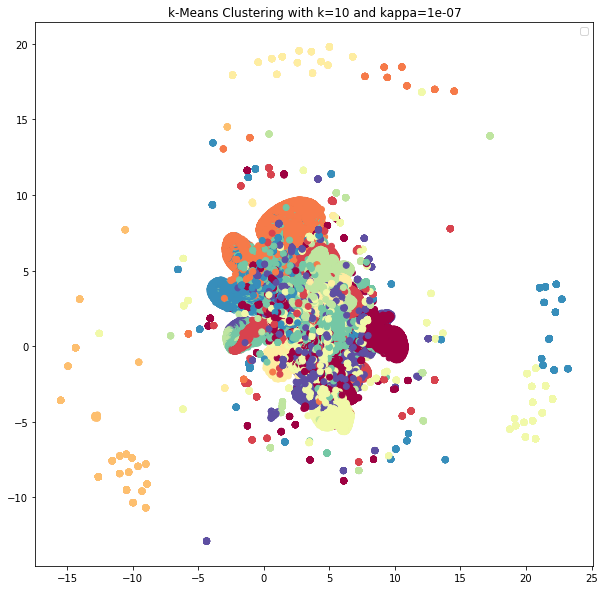

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [28]:
# parameters
k = 10
kappa = 1e-7

session_to_cluster = visualise_cluster_closest_sessions(sequences, k=k, kappa=kappa)

In [ ]:
sequences['Cluster'] = sequences['session_id'].map(session_to_cluster)

Cluster sizes:
0    1290
1     215
2     128
3     173
4     202
5      96
6     381
7      28
8     280
9    1384
Name: Cluster, dtype: int64 0    30.883409
1     5.147235
2     3.064400
3     4.141729
4     4.836007
5     2.298300
6     9.121379
7     0.670338
8     6.703376
9    33.133828
Name: Cluster, dtype: float64

Mean session lengths:
Cluster
0    48.904651
1    32.655814
2    21.640625
3    15.930636
4    25.663366
5    17.458333
6    31.540682
7     9.892857
8    35.071429
9    36.372110
Name: session_length, dtype: float64

Average Time between Actions:
Cluster
0    29.342923
1    50.572489
2    34.231051
3    29.202435
4    26.802782
5    29.388774
6    32.617579
7     5.028003
8    32.226471
9    59.695377
Name: avg_time_between_actions, dtype: float64

Average Session Duration:
Cluster
0    1029.707752
1     869.772093
2     500.921875
3     371.930636
4     441.356436
5     297.187500
6     817.480315
7      54.428571
8     724.203571
9     972.438584
Name: session_dura

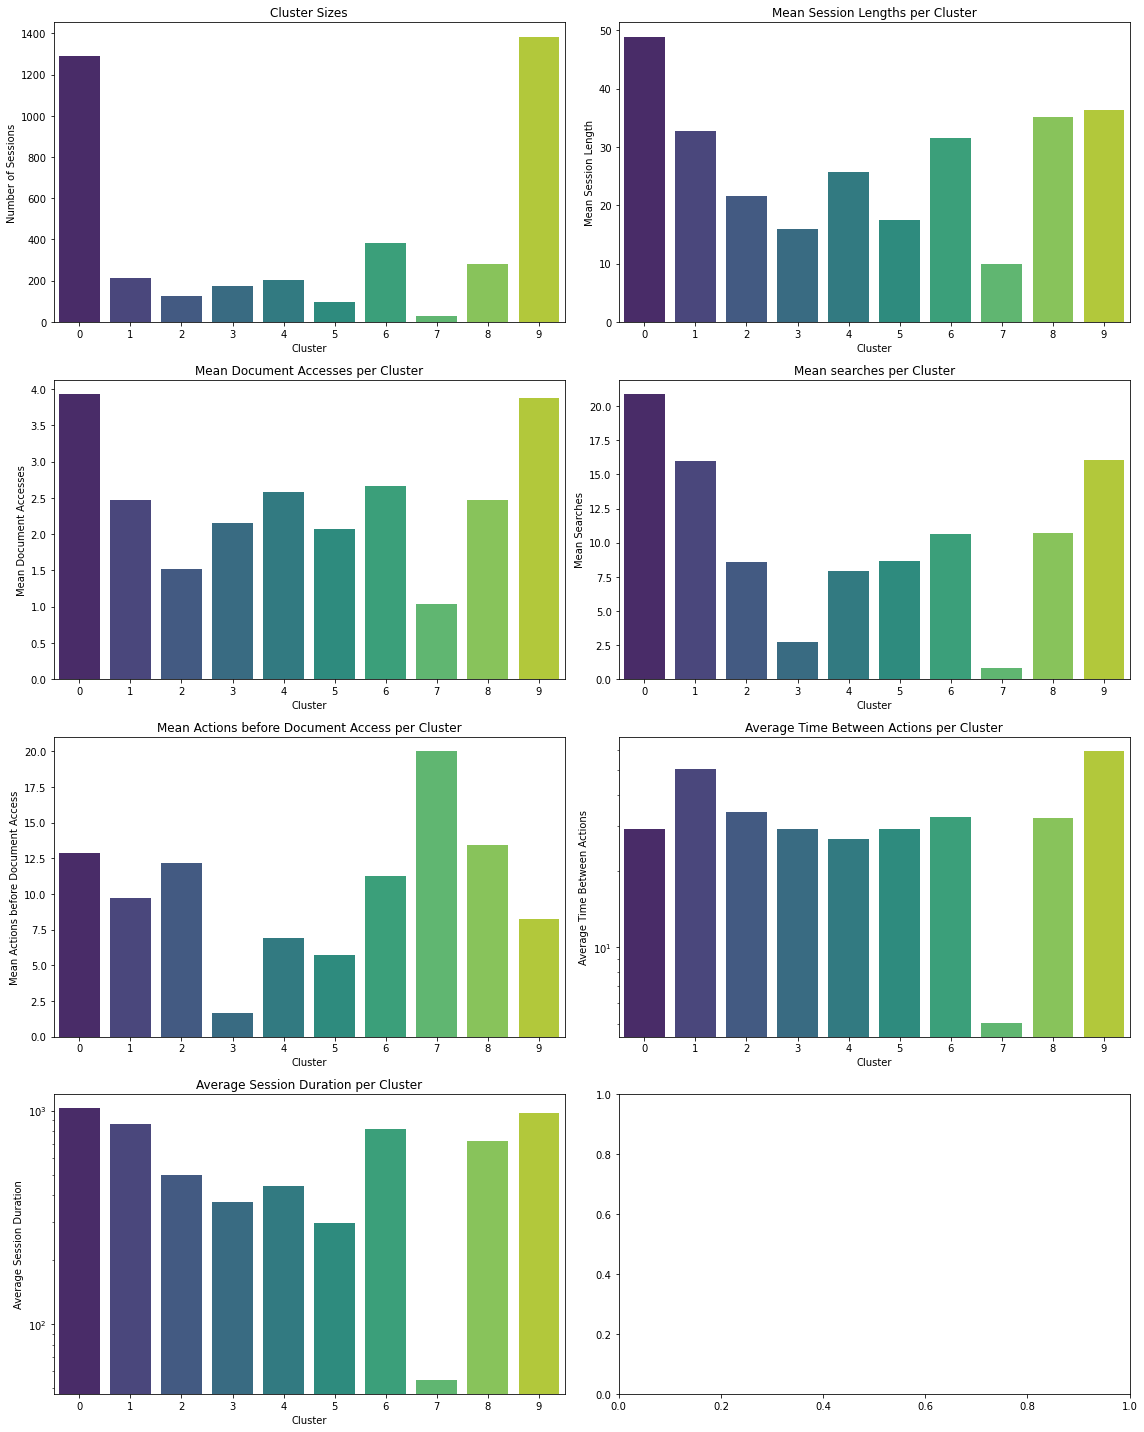

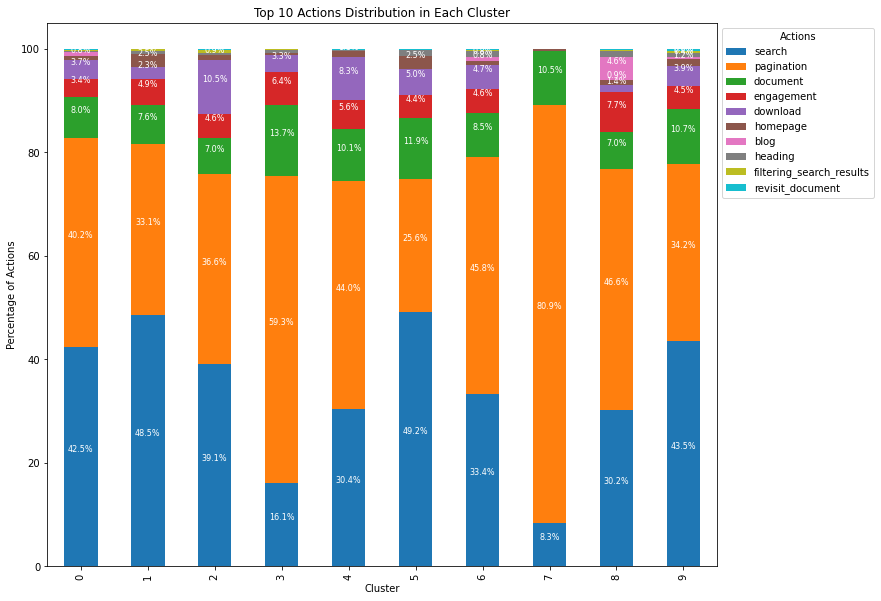

In [ ]:
sequences['Cluster'] = sequences['session_id'].map(session_to_cluster)
sequences['Action_list'] = sequences['Encoded_Sequence'].apply(lambda x: [action_dict[int(action)] for action in x.split()])
calculate_features(sequences, 'Action_list', 'timestamp_list')
visualize_clusters(sequences,f"html_files/Clusters_k_{k}_kappa_{kappa}",'Cluster', 'Action_list')